In [ ]:
import pandas as pd
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import r2_score, mean_squared_error

In [222]:
data = pd.read_csv("../Datum/student-scores.csv")
df = pd.DataFrame(data)
df.count()

Hours    499
Score    499
dtype: int64

In [223]:
df = df.dropna(subset=["Hours", "Score"])

In [224]:
X = df[["Hours"]]
y = df["Score"]

In [225]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, degree=1):
        self.degree = degree

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Ensure DataFrame
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=["Hours"])
        else:
            X = X.copy()

        if (self.degree >= 2):
            X["Hours_squared"] = X["Hours"] ** 2
            
        return X


In [226]:
model_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("feature_engineer", FeatureEngineer()),
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=10))
])

In [227]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [228]:
model_pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('imputer', ...), ('feature_engineer', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"missing_values missing_values: int, float, str, np.nan, None or pandas.NA, default=np.nanThe placeholder for the missing values. All occurrences of`missing_values` will be imputed. For pandas' dataframes withnullable integer dtypes with missing values, `missing_values`can be set to either `np.nan` or `pd.NA`.",nan
,"strategy strategy: str or Callable, default='mean'The imputation strategy.- If ""mean"", then replace missing values using the mean along each column. Can only be used with numeric data.- If ""median"", then replace missing values using the median along each column. Can only be used with numeric data.- If ""most_frequent"", then replace missing using the most frequent value along each column. Can be used with strings or numeric data. If there is more than one such value, only the smallest is returned.- If ""constant"", then replace missing values with fill_value. Can be used with strings or numeric data.- If an instance of Callable, then replace missing values using the scalar statistic returned by running the callable over a dense 1d array containing non-missing values of each column... versionadded:: 0.20 strategy=""constant"" for fixed value imputation... versionadded:: 1.5 strategy=callable for custom value imputation.",'median'
,"fill_value fill_value: str or numerical value, default=NoneWhen strategy == ""constant"", `fill_value` is used to replace alloccurrences of missing_values. For string or object data types,`fill_value` must be a string.If `None`, `fill_value` will be 0 when imputing numericaldata and ""missing_value"" for strings or object data types.",None
,"copy copy: bool, default=TrueIf True, a copy of X will be created. If False, imputation willbe done in-place whenever possible. Note that, in the following cases,a new copy will always be made, even if `copy=False`:- If `X` is not an array of floating values;- If `X` is encoded as a CSR matrix;- If `add_indicator=True`.",True
,"add_indicator add_indicator: bool, default=FalseIf True, a :class:`MissingIndicator` transform will stack onto outputof the imputer's transform. This allows a predictive estimatorto account for missingness despite imp

In [229]:
param_grid = {
    "feature_engineer__degree": [1, 2],
    "model__alpha": [0.01, 0.1, 1.0, 10.0]
}

In [230]:
cv = KFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

In [231]:
grid = GridSearchCV(
    model_pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring="r2"
)

grid.fit(X_train, y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...e(alpha=10))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'feature_engineer__degree': [1, 2], 'model__alpha': [0.01, 0.1, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'r2'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",KFold(n_split... shuffle=True)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displaye

In [232]:
print("Best parameters:", grid.best_params_)
print("Best CV R²:", grid.best_score_)

Best parameters: {'feature_engineer__degree': 2, 'model__alpha': 1.0}
Best CV R²: 0.4003888883333332


In [233]:
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)

print("Test R²:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


Test R²: 0.5753898740783794
RMSE: 6.4280548720855375


In [234]:
cv_scores = cross_val_score(
    model_pipeline,
    X, y,
    cv=cv,
    scoring="r2"
)

print("CV R² Mean:", cv_scores.mean())

CV R² Mean: 0.16521489441115592


In [235]:
# Get the trained pipeline
best_model = grid.best_estimator_

# Extract the preprocessor and model
preprocessor = best_model.named_steps["scaler"]  # StandardScaler is after FeatureEngineer
model = best_model.named_steps["model"]

# Feature names after FeatureEngineer
X_sample = best_model.named_steps["feature_engineer"].transform(X_train)
feature_names = X_sample.columns.tolist()

# Get coefficients
coefs = model.coef_
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefs
})

print(coef_df)

         Feature  Coefficient
0          Hours    20.503996
1  Hours_squared   -18.031512


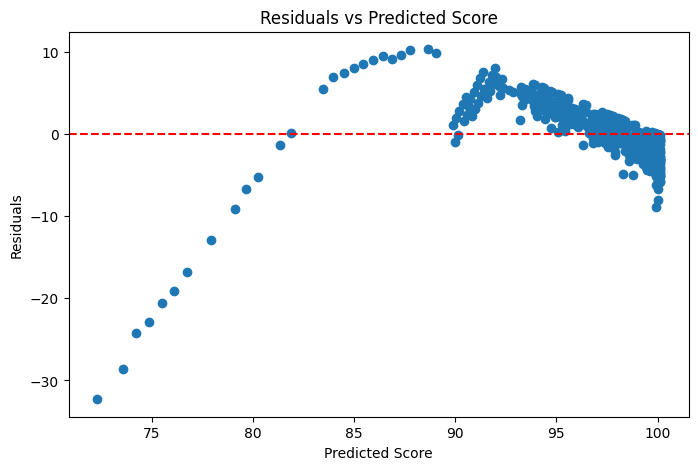

In [236]:
import matplotlib.pyplot as plt

# Predict on training data
y_train_pred = best_model.predict(X_train)
residuals = y_train - y_train_pred

plt.figure(figsize=(8,5))
plt.scatter(y_train_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Score")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Score")
plt.show()


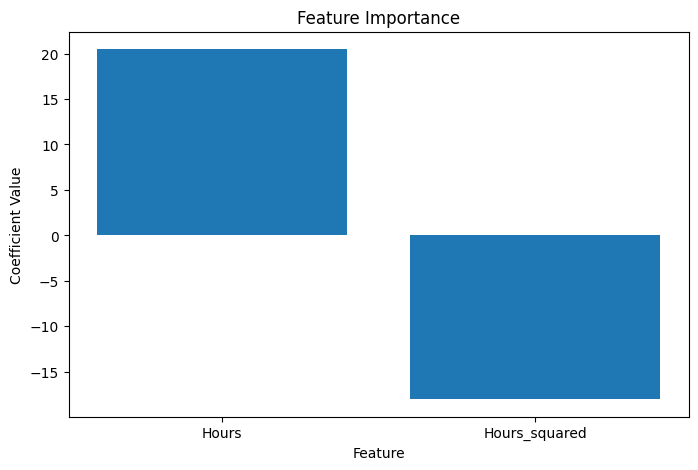

In [237]:
# Plot coefficients
plt.figure(figsize=(8,5))
plt.bar(coef_df["Feature"], coef_df["Coefficient"])
plt.xlabel("Feature")
plt.ylabel("Coefficient Value")
plt.title("Feature Importance")
plt.show()


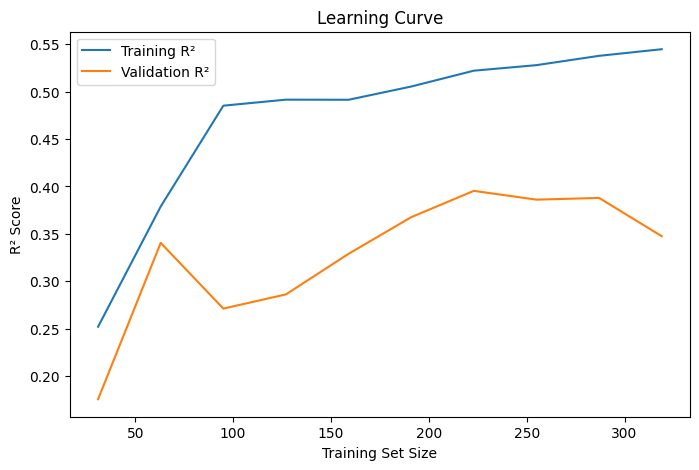

In [238]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Use your tuned pipeline (without refitting)
estimator = grid.best_estimator_

train_sizes, train_scores, val_scores = learning_curve(
    estimator,
    X_train,
    y_train,
    cv=5,
    scoring="r2",
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42
)

# Mean scores
train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, label="Training R²")
plt.plot(train_sizes, val_mean, label="Validation R²")
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.title("Learning Curve")
plt.legend()
plt.show()


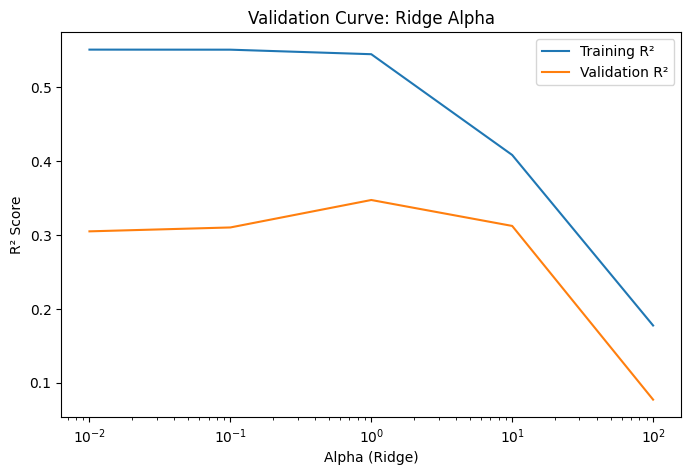

In [239]:
from sklearn.model_selection import validation_curve

param_range = [0.01, 0.1, 1, 10, 100]

train_scores, val_scores = validation_curve(
    grid.best_estimator_,
    X_train,
    y_train,
    param_name="model__alpha",
    param_range=param_range,
    cv=5,
    scoring="r2"
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(8,5))
plt.plot(param_range, train_mean, label="Training R²")
plt.plot(param_range, val_mean, label="Validation R²")
plt.xscale("log")
plt.xlabel("Alpha (Ridge)")
plt.ylabel("R² Score")
plt.title("Validation Curve: Ridge Alpha")
plt.legend()
plt.show()


Top 5 largest errors:
    Hours  y_true     y_pred   residual
0     1.0    35.0  71.622024 -36.622024
2     2.0    42.0  72.949653 -30.949653
9     5.5    63.0  77.347132 -14.347132
11    6.5    67.0  78.532348 -11.532348
33   17.5   100.0  89.480982  10.519018


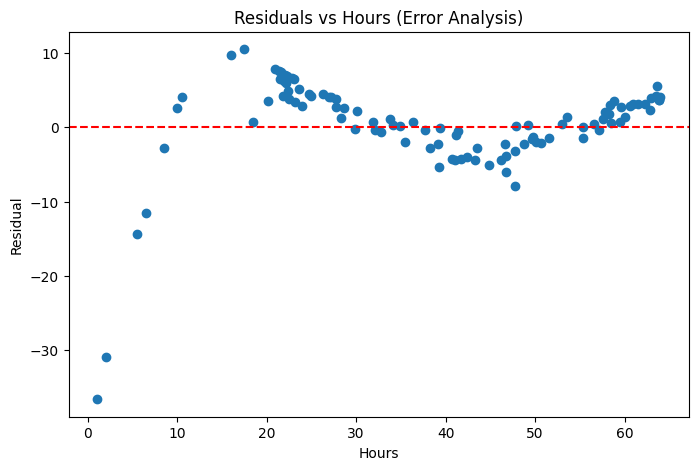

In [240]:
# Predict on test set
y_pred = grid.best_estimator_.predict(X_test)
residuals = y_test - y_pred

# Combine with input for analysis
error_df = X_test.copy()
error_df["y_true"] = y_test
error_df["y_pred"] = y_pred
error_df["residual"] = residuals

# Top 5 worst predictions
print("Top 5 largest errors:")
print(error_df.reindex(residuals.abs().sort_values(ascending=False).index).head())

# Plot residuals vs Hours
plt.figure(figsize=(8,5))
plt.scatter(X_test["Hours"], residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Hours")
plt.ylabel("Residual")
plt.title("Residuals vs Hours (Error Analysis)")
plt.show()


In [241]:
new_data = pd.DataFrame({
    "Hours": [1.5, 3.0, 5.0, 7.0, 9.0, 10.5]
})

new_data

,Hours
0,1.5
1,3.0
2,5.0
3,7.0
4,9.0
5,10.5


In [242]:
predictions = grid.best_estimator_.predict(new_data)

result = new_data.copy()
result["Predicted_Score"] = predictions
result

,Hours,Predicted_Score
0,1.5,72.289794
1,3.0,74.245635
2,5.0,76.742656
3,7.0,79.113088
4,9.0,81.356929
5,10.5,82.956735
